In [1]:
import os
import pickle
import numpy as np
import json
import string
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf

In [2]:
print(tf.__version__) 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('you must enable GPU! Go to:')
  print('\nRuntime')
  print('\tChange runtime type')
  print('\t\tHardware Accelerator: GPU')

  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.8.2
Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

PATH_IMAGES = '/content/drive/MyDrive/Campilongo/images'
PATH_FEATURES = '/content/drive/MyDrive/Campilongo/features'
PATH_CAPTIONS = '/content/drive/MyDrive/Campilongo/captions'
PATH_MODEL = '/content/drive/MyDrive/Campilongo/models'
PATH_OTHERS = '/content/drive/MyDrive/Campilongo/others'

Mounted at /content/drive


In [4]:
# Loading features previously extracted with VGG16 for training
f = open(os.path.join(PATH_FEATURES, 'features_vgg16_train.pickle'), "r+b")
features_train = pickle.load(f)
len(features_train)

# Feature train array size
first_feature = list(features_train.items())[0][1]
print("Features arrays size: ", first_feature.size)
features_train_sorted_id = sorted(features_train.keys(), key=lambda x:x.lower())
print("Train set number of occurences: ", len(features_train_sorted_id))

Features arrays size:  4096
Train set number of occurences:  10000


In [5]:
# Loading features previously extracted with VGG16 for testing
f = open(os.path.join(PATH_FEATURES, 'features_vgg16_test.pickle'), "r+b")
features_test = pickle.load(f)
len(features_test)

# Feature test array size
first_feature = list(features_test.items())[0][1]
print("Features arrays size: ", first_feature.size)
features_test_sorted_id = sorted(features_test.keys(), key=lambda x:x.lower())
print("Test set number of occurences: ", len(features_test_sorted_id))

Features arrays size:  4096
Test set number of occurences:  1000


In [6]:
# Loading captions from JSON file
f = open(os.path.join(PATH_CAPTIONS, 'image_name_captions.json'))
captions_json = json.load(f)
print("Captions_json length: ", len(captions_json))

# Creating a list of only captions, cleaning up the extra characters from the single captions like,
# dot, comma, extra spaces, extra digits
captions_cleaned = dict()
captions_list_train = []
captions_list_test = []
captions_list = []
captions_dict_train = dict()
captions_dict_test = dict()
for i,j in captions_json.items():
    a = j.lower()
    b = a.replace('[^A-Za-z]', '')
    c = b.replace('\s+', ' ')
    d = 'startseq ' + " ".join([word for word in c.split() if len(word)>1]) + ' endseq'
    f = d.translate(str.maketrans('','', string.punctuation))
    captions_cleaned[i] = f
    captions_list.append(f)
print("Captions_cleaned length: ", len(captions_cleaned))
captions_cleaned_sorted_id = sorted(captions_cleaned.keys(), key=lambda x:x.lower())

print("Filtering the captions for training")
for i in features_train_sorted_id:
    captions_list_train.append(captions_cleaned[i])
    captions_dict_train[i] = captions_cleaned[i]
print("captions_list_train length: ", len(captions_list_train))
print("captions_dict_train length: ", len(captions_dict_train))

print("Filtering the captions for testing")
for i in features_test_sorted_id:
    captions_list_test.append(captions_cleaned[i])
    captions_dict_test[i] = captions_cleaned[i]
print("captions_list_train length: ", len(captions_list_test))
print("captions_dict_train length: ", len(captions_dict_test))

Captions_json length:  82783
Captions_cleaned length:  82783
Filtering the captions for training
captions_list_train length:  10000
captions_dict_train length:  10000
Filtering the captions for testing
captions_list_train length:  1000
captions_dict_train length:  1000


In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions_list_train)
vocab_size = len(tokenizer.word_index) + 1
print("Number of elements into the vocabolary: ", vocab_size)

Number of elements into the vocabolary:  5114


In [8]:
#maximum length of a caption
max_length = max(len(caption.split()) for caption in captions_list_train)
print("Maximum length of a caption in the train set: ", max_length)

Maximum length of a caption in the train set:  45


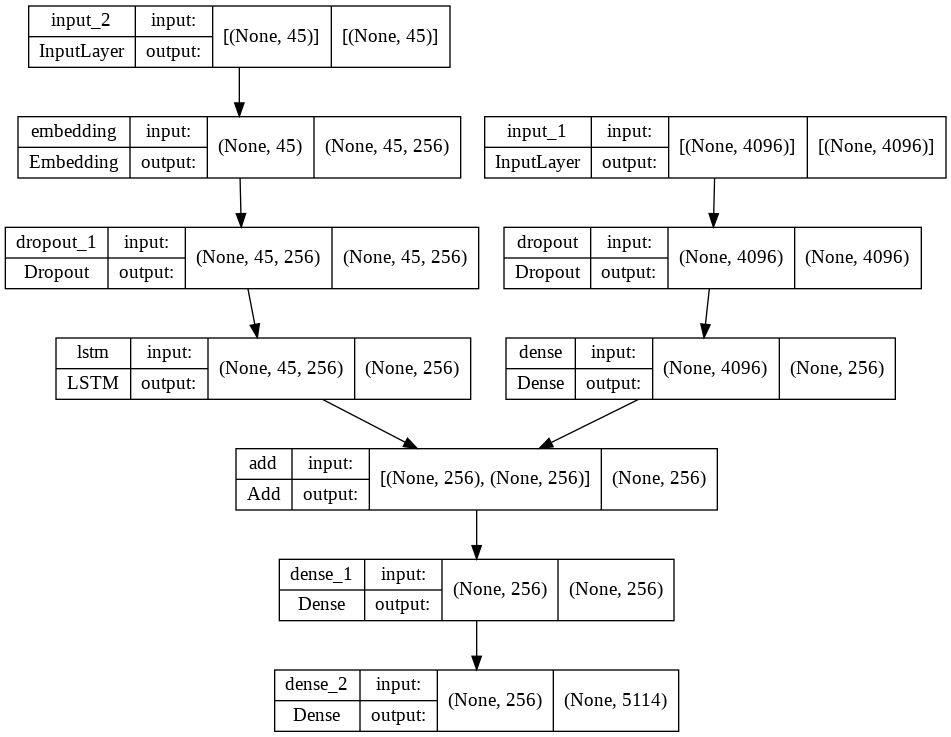

In [9]:
# Model
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [10]:
# organize the image dataset and the caption dataset
train_set_features = []
id_imgs = []
train_set_features_captions = {}
for i in features_train_sorted_id:
    id_imgs.append(i)
    train_set_features.append(features_train[i])
train_set_captions = captions_list_train

#print(id_imgs[700])
#print(train_set_captions[700])

# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            #print(key)
            caption = mapping[key]
            # encode the sequence
            seq = tokenizer.texts_to_sequences([caption])[0]
            #print("seq: ", seq)
            # split the sequence into X, y pairs
            for i in range(1, len(seq)):
                # split into input and output pairs
                in_seq, out_seq = seq[:i], seq[i]
                #print("in_seq: ", in_seq)
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                #print("out_seq: ", out_seq)
                    
                # store the sequences
                X1.append(features[key][0])
                X2.append(in_seq)
                y.append(out_seq)
                #print(X1, X2)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                #print(X1, X2)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [11]:
# Train the model
epochs = 20
batch_size = 64
train = list(features_train.keys())
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(id_imgs, captions_dict_train, features_train, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

156/156 [==============================] - 27s 175ms/step - loss: 1.8645


In [12]:
# save the model VGG16
#model.save(PATH_MODEL+'/model_20_64_vgg16.h5')

In [ ]:
# load the model VGG16
#model = keras.models.load_model(PATH_MODEL+'/model_20_64_vgg16.h5')

In [13]:
# retrieve word from vocabolary
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [14]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [15]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual = []
predicted = []

for key in tqdm(features_test.keys()):
    # get actual caption
    caption = captions_dict_test[key]
    # predict the caption for image
    y_pred = predict_caption(model, features_test[key], tokenizer, max_length) 
    # split into words
    actual_captions = caption.split()
    #print("Real caption: ", caption)
    #print("Predicted caption: ", y_pred)
    y_pred = y_pred.split()
    #print("Nuovo y_pred: ", y_pred)
    # append to the list
    actual.append([actual_captions])
    predicted.append(y_pred)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.337931
BLEU-2: 0.134527
BLEU-3: 0.083037
BLEU-4: 0.031675


In [17]:
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(PATH_IMAGES, image_name)
    image = Image.open(img_path)
    caption = captions_dict_test[image_id]
    print('---------------------Actual---------------------')
    print(caption)
    # predict the caption
    y_pred = predict_caption(model, features_test[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq two people standing among mixture of cows horses and pigs endseq
--------------------Predicted--------------------
startseq herd of animals are in the meadow endseq


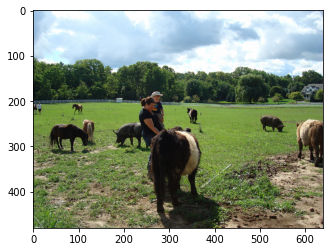

In [18]:
# try the model!
generate_caption("COCO_train2014_000000576684.jpg")